This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats

from sklearn.model_selection import train_test_split

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/omitted_data/')

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 
data_file = '../../data/interim/generated_data/Simplified_Teusink_yeast_1.5.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

# Leaving out internal species concentrations

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
holey_data = pd.concat([data[fluxes], data[external], data[enzymes]], axis=1)


In [6]:
BIOMD64 = BMCA.BMCA(Teusink_ant, holey_data)

Model does not contain SBML fbc package information.


../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Running ADVI

In [7]:
def run_BayesInf(BMCA_obj, n_samp=1):
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in holey_data.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))

        # trace_prior = pm.sample_prior_predictive(samples=1000)
        
        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))

        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        # supposedly chi_t would be in the order listed in ss tellurium

        pm.Deterministic('chi_t', chi_t)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?
        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T) # yn?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,317.3


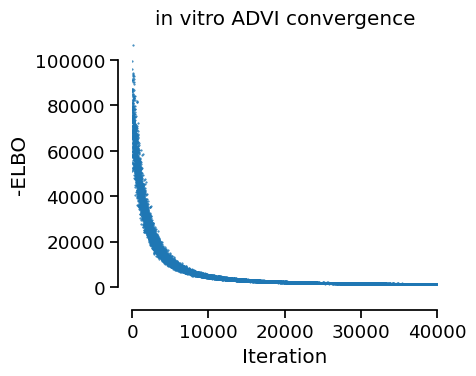

In [8]:
traces = run_BayesInf(BIOMD64, n_samp=3)

### Plotting ADVI results

In [9]:
Ex_0 = (traces[0]['posterior']['Ex']).to_numpy().squeeze()
Ex_1 = (traces[1]['posterior']['Ex']).to_numpy().squeeze()
Ex_2 = (traces[2]['posterior']['Ex']).to_numpy().squeeze()
all_Exs = [Ex_0, Ex_1, Ex_2]

In [10]:
# concatenate all Ex traces
Ex = np.concatenate(all_Exs)
med_Ex_advi = np.median(Ex, axis=0)
# med_Ey_advi = np.median(Ey, axis=0)

## Plotting MCC and FCC comparisons

In [11]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [12]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


### Negative predictions

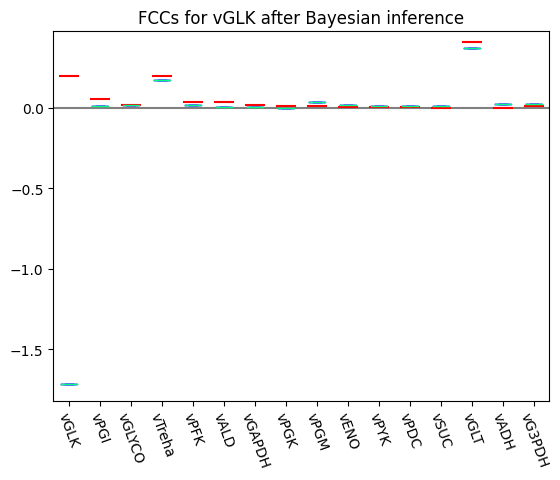

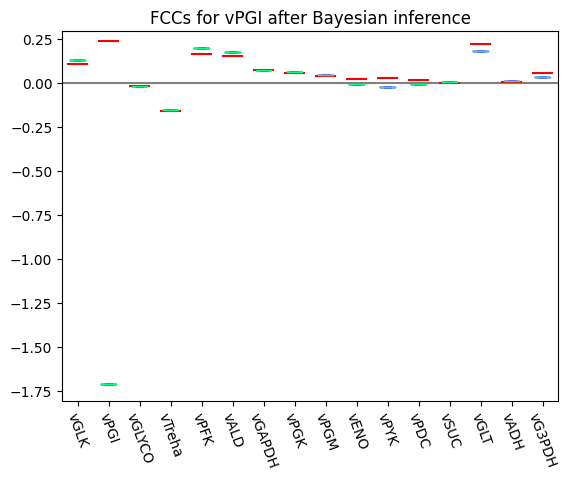

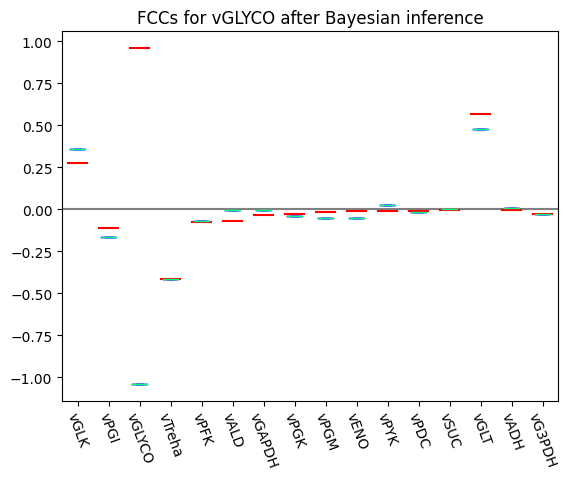

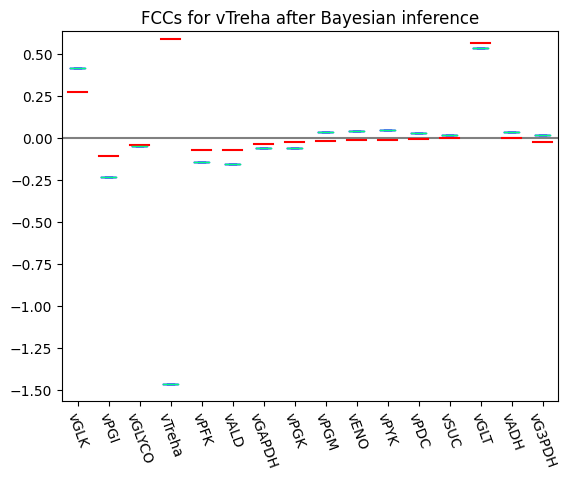

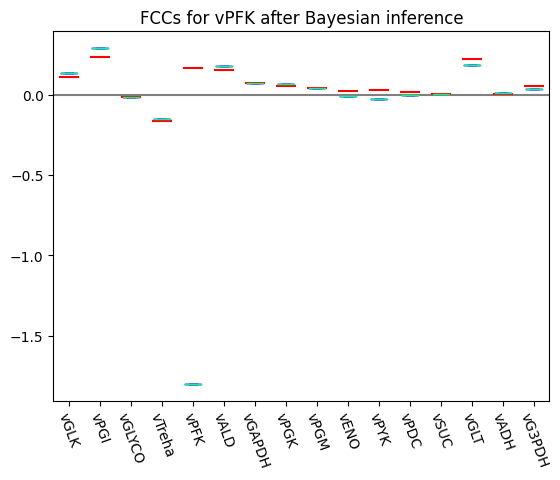

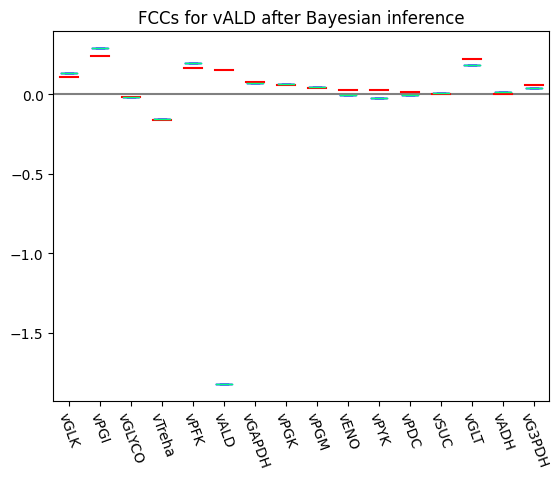

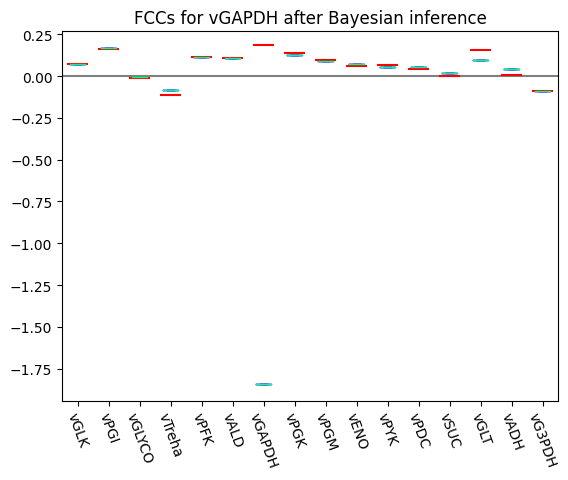

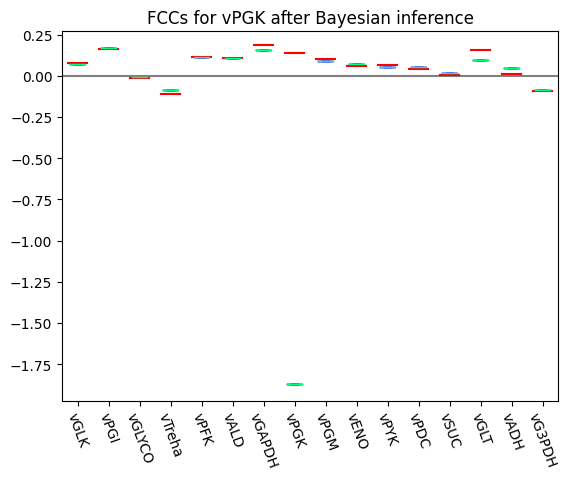

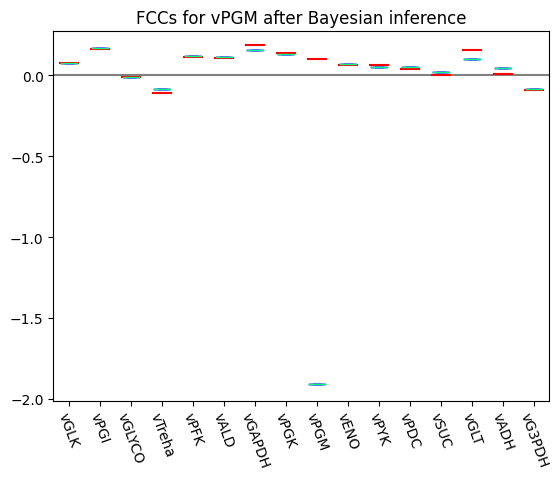

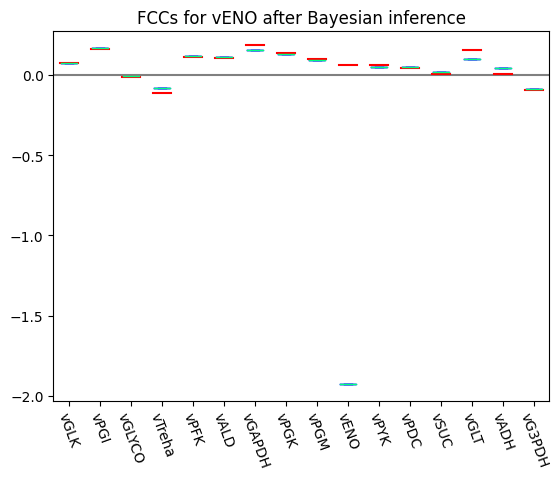

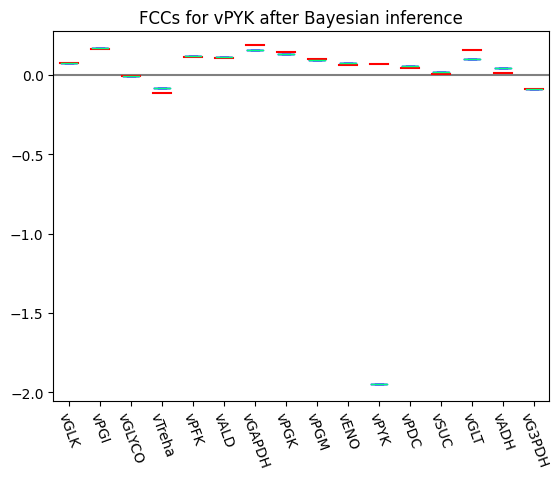

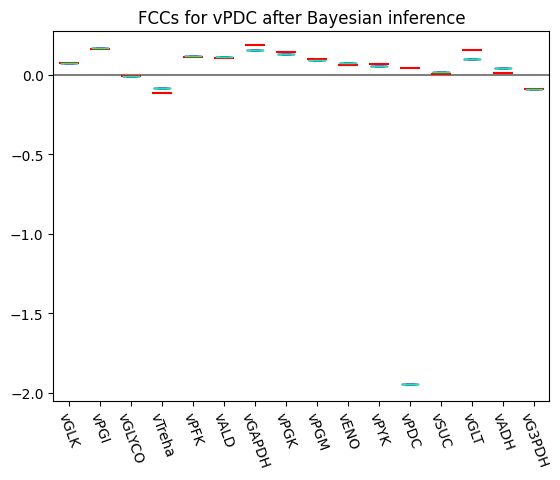

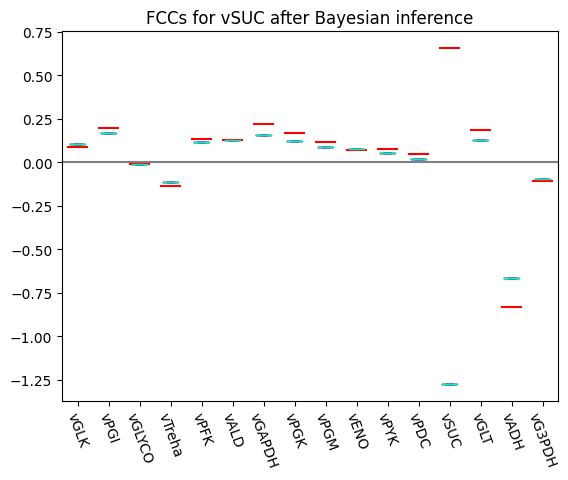

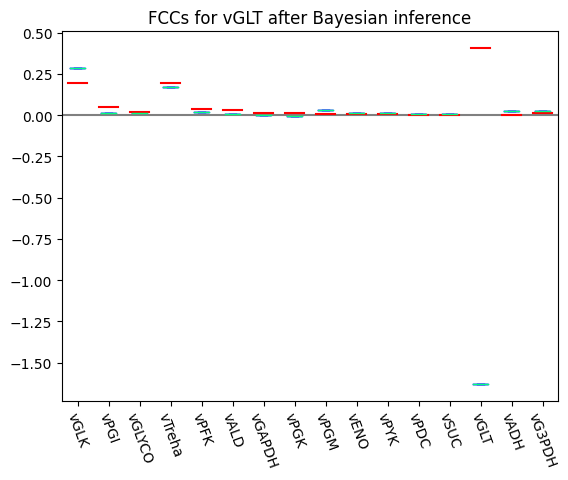

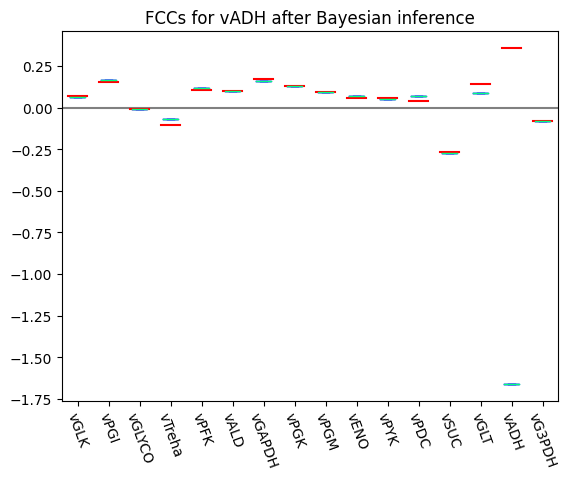

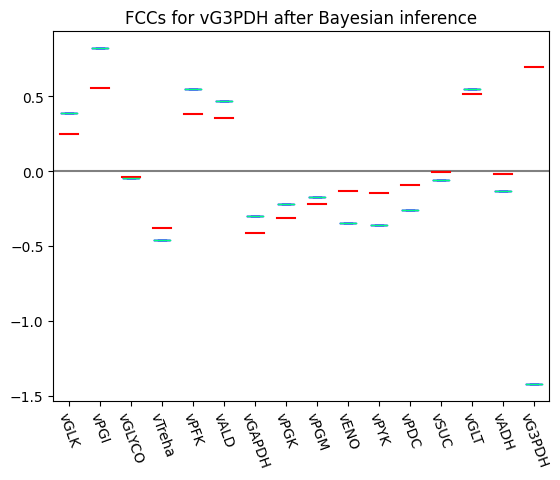

In [13]:
postCCC, postFCC = estimate_CCs(BIOMD64, med_Ex_advi)
for i,rxnID in enumerate(r.getReactionIds()):
    FCCs = -pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())
    # FCCs = pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())

    FCCs.plot(kind='box', colormap='winter')
    plt.title(f'FCCs for {rxnID} after Bayesian inference')
    plt.axhline(0, c='gray')

    for i,val in enumerate(gtFCC.loc[rxnID]): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[rxnID]), # From the left
                xmax = (i+0.8)/len(gtFCC[rxnID]), 
                c='red') # To the right
    plt.xticks(rotation=-70)
# plt.ylim((-1,3))

## Evaluating FCC ranking

In [14]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
gtFCC_rankings

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
vGLK,NaN,3.0,6.0,2.0,4.0,5.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vPGI,5.0,NaN,13.0,3.0,2.0,4.0,6.0,7.0,9.0,11.0,10.0,12.0,15.0,1.0,14.0,8.0
vGLYCO,3.0,4.0,NaN,2.0,5.0,6.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vTreha,2.0,3.0,6.0,NaN,4.0,5.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vPFK,5.0,1.0,13.0,3.0,NaN,4.0,6.0,7.0,9.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vALD,5.0,1.0,13.0,4.0,3.0,NaN,6.0,7.0,9.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vGAPDH,9.0,1.0,13.0,5.0,4.0,6.0,NaN,3.0,7.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vPGK,9.0,2.0,13.0,5.0,4.0,6.0,1.0,NaN,7.0,11.0,10.0,12.0,15.0,3.0,14.0,8.0
vPGM,9.0,2.0,13.0,6.0,5.0,7.0,1.0,4.0,NaN,11.0,10.0,12.0,15.0,3.0,14.0,8.0
vENO,10.0,2.0,13.0,6.0,5.0,7.0,1.0,4.0,8.0,NaN,11.0,12.0,15.0,3.0,14.0,9.0


In [15]:
postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
# m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
postFCC_med_rankings

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
vGLK,NaN,9.0,7.0,2.0,6.0,13.0,15.0,14.0,3.0,8.0,10.0,11.0,12.0,1.0,4.0,5.0
vPGI,5.0,NaN,11.0,4.0,1.0,3.0,6.0,7.0,8.0,13.0,10.0,14.0,15.0,2.0,12.0,9.0
vGLYCO,3.0,4.0,NaN,2.0,5.0,15.0,14.0,8.0,6.0,7.0,10.0,11.0,13.0,1.0,12.0,9.0
vTreha,2.0,3.0,9.0,NaN,5.0,4.0,7.0,6.0,12.0,10.0,8.0,13.0,15.0,1.0,11.0,14.0
vPFK,5.0,1.0,11.0,4.0,NaN,3.0,6.0,7.0,8.0,13.0,10.0,14.0,15.0,2.0,12.0,9.0
vALD,5.0,1.0,11.0,4.0,2.0,NaN,6.0,7.0,8.0,13.0,10.0,14.0,15.0,3.0,12.0,9.0
vGAPDH,9.0,1.0,15.0,8.0,3.0,4.0,NaN,2.0,6.0,10.0,12.0,11.0,14.0,5.0,13.0,7.0
vPGK,9.0,1.0,15.0,8.0,3.0,4.0,2.0,NaN,6.0,10.0,12.0,11.0,14.0,5.0,13.0,7.0
vPGM,9.0,1.0,15.0,8.0,4.0,5.0,2.0,3.0,NaN,10.0,12.0,11.0,14.0,6.0,13.0,7.0
vENO,10.0,1.0,15.0,9.0,4.0,5.0,2.0,3.0,7.0,NaN,12.0,11.0,14.0,6.0,13.0,8.0


In [16]:
for i in r.getReactionIds():
    a = gtFCC_rankings.loc[i].values
    b = postFCC_med_rankings.loc[i].values
    spcorr = stats.spearmanr(a,b,nan_policy='omit')
    print(i, spcorr)

vGLK SpearmanrResult(correlation=0.2857142857142857, pvalue=0.30193635132254915)
vPGI SpearmanrResult(correlation=0.9607142857142856, pvalue=1.3027489790343175e-08)
vGLYCO SpearmanrResult(correlation=0.6714285714285714, pvalue=0.006127766788820088)
vTreha SpearmanrResult(correlation=0.882142857142857, pvalue=1.3558210624788787e-05)
vPFK SpearmanrResult(correlation=0.9642857142857142, pvalue=7.07230300920413e-09)
vALD SpearmanrResult(correlation=0.9642857142857142, pvalue=7.07230300920413e-09)
vGAPDH SpearmanrResult(correlation=0.932142857142857, pvalue=4.2412182315433434e-07)
vPGK SpearmanrResult(correlation=0.9392857142857143, pvalue=2.0945801936685295e-07)
vPGM SpearmanrResult(correlation=0.9392857142857143, pvalue=2.0945801936685295e-07)
vENO SpearmanrResult(correlation=0.9357142857142856, pvalue=3.010645621400729e-07)
vPYK SpearmanrResult(correlation=0.9392857142857143, pvalue=2.0945801936685295e-07)
vPDC SpearmanrResult(correlation=0.9357142857142856, pvalue=3.010645621400729e-07)